In [16]:
import random
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from hiv_patient import HIVPatient
from sklearn.ensemble import ExtraTreesRegressor , RandomForestRegressor
from copy import deepcopy

In [17]:
def greedy_action(tree, state, env):
    rew = []
    for j in range(4):
        input_a = np.zeros((1, 8))
        input_a[:, :6] = state
        input_a[:, 6:] = env.action_set[j]
        rew.append(tree.predict(input_a))

    return np.argmax(rew)

In [18]:
# Replay buffer class
class ReplayBuffer:
    def __init__(self, 
                 env,
                 gamma=0.98,
                 epsilon=0.15,
                 nb_actions=4,
                 nb_patient=30,
                 duration=200):
        

        self.env = env
        self.gamma = gamma 
        self.epsilon = epsilon
        self.nb_actions = nb_actions
        self.nb_patients = nb_patient
        self.duration = duration
        self.data = np.zeros((self.duration * self.nb_patients, 15))


        print('Initializing replay buffer RB_0:')
        for j in tqdm(range(self.nb_patients)):
            self.env.reset()
            for k in range(self.duration):
                s = self.env.state()
                idx_a = np.random.randint(self.nb_actions)
                a = self.env.action_set[idx_a]
                s_, r, _, _ = self.env.step(idx_a)

                # state size 6,  action size 2,  reward size 1
                self.data[j*self.duration + k, : 6] = s # state
                self.data[j*self.duration + k, 6:8] = a # action
                self.data[j*self.duration + k, 8] = r # reward
                self.data[j*self.duration + k, 9: ]  = s_ # new state


    def update_set(self, tree, data):
        self.data_new = np.zeros((self.duration * self.nb_patients, 15))
        for j in range(self.nb_patients):
            self.env.reset()
            for k in range(self.duration):
                # epsilon greedy
                s = self.env.state() 
                if np.random.rand() < self.epsilon:
                    idx_a = np.random.randint(self.nb_actions)

                else :
                    idx_a = greedy_action(tree, s, self.env)
                
                
                a = self.env.action_set[idx_a]
                s_, r, _, _ = self.env.step(idx_a)
                self.data_new[j*self.duration + k, : 6] = s # state
                self.data_new[j*self.duration + k, 6:8] = a # action
                self.data_new[j*self.duration + k, 8] = r  # reward
                self.data_new[j*self.duration + k, 9: ] = s_ # new state
                
        update_data = np.concatenate([data, self.data_new])
        
        return update_data


    def __len__(self):
        return len(self.data)

In [19]:
class ExtraTree:
    def __init__(self, 
                 config,
                 env,
                 nb_epoch) -> None:
        self.env = env
        self.nb_epoch = nb_epoch
        self.duration = config['duration']
        self.nb_patient = config['nb_patients']
        self.gamma = config['gamma']
        self.buffer = ReplayBuffer(env,
                                 gamma=self.gamma,
                                 epsilon=0.15,
                                 nb_actions=len(self.env.action_set),
                                 duration=self.duration, 
                                 nb_patient=self.nb_patient)
        self.data = self.buffer.data
        self.Qtree = ExtraTreesRegressor(n_estimators=100)
        # self.Qtree = RandomForestRegressor(n_estimators=100)


        self.checkpoints = []
        self.cumulated_rewards = []
    
    def train(self):

        # First step
        X, y = self.data[:, :8], self.data[:, 8]
        self.Qtree.fit(X,y)
        self.checkpoints.append(deepcopy(self.Qtree))

        for epoch in tqdm(range(self.nb_epoch-1)):

            #We update the training set
            self.data = self.buffer.update_set(self.Qtree, self.data)

            X_ = np.zeros((self.data.shape[0], 8))
            X_[:, :6]= self.data[:, 9:] # s prime
            y_res = np.zeros((self.data.shape[0], 4)) # taking result of each action

            # We loop on all possible actions 
            for idx_a in range(4):
                a = self.env.action_set[idx_a]
                X_[:, 6:] = a
                y_pred = self.Qtree.predict(X_)
                y_res[:, idx_a] = y_pred

            # We take the argmax and update our training set
            idx_max = np.argmax(y_res, axis=1)
            target = self.data[:, 8] + self.gamma * np.take_along_axis(y_res, idx_max[:,None], axis=1)[:, 0]
            

            # fitting the tree with the new training set
            X, y = self.data[:, :8], target
            self.Qtree.fit(X,y)
            self.checkpoints.append(deepcopy(self.Qtree))

    def test(self):
        nb_trees = len(self.checkpoints)
        actions = np.zeros((1+nb_trees, self.duration))
        states = np.zeros((1+nb_trees, self.duration, 6))
        for i in trange(nb_trees+1):
            self.env.reset(mode="unhealthy")
            cum_reward_tree = 0
            for k in range(self.duration):
                s = self.env.state()
                y_res = []
                if i == 0: # Random behaviour
                    idx_a = np.random.randint(4)

                else: # Fitted Q Tree
                    for idx_a in range(4):
                        a = self.env.action_set[idx_a]
                        y_pred = self.checkpoints[i-1].predict(np.concatenate([s,a]).reshape(1, -1))
                        y_res.append(y_pred)
                    idx_a = np.argmax(y_res)
                    
                a = self.env.action_set[idx_a]
                s_, r, _, _ = self.env.step(idx_a)
                cum_reward_tree += r
                actions[i, k] = idx_a
                states[i, k, :] = s

            self.cumulated_rewards.append(cum_reward_tree)
        return actions, states, self.cumulated_rewards


In [20]:
patient = HIVPatient()
config_test = {'gamma': 0.98,
               'nb_patients': 30,
               'duration': 200 }


Tree_test = ExtraTree(config=config_test,
                      env=patient,
                      nb_epoch= 10)

Initializing replay buffer RB_0:


  0%|          | 0/30 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [11]:
Tree_test.train()

100%|██████████| 9/9 [28:50<00:00, 192.26s/it]


In [13]:
actions, states, cum_reward = Tree_test.test()

100%|██████████| 11/11 [01:09<00:00,  6.30s/it]


In [12]:
import pickle
filename = 'model_extratree.sav'
pickle.dump(Tree_test, open(filename, 'wb'))

In [23]:
import pickle
filename = 'model_extratree.sav'
tree_trained = pickle.load(open(filename, 'rb'))

EOFError: Ran out of input

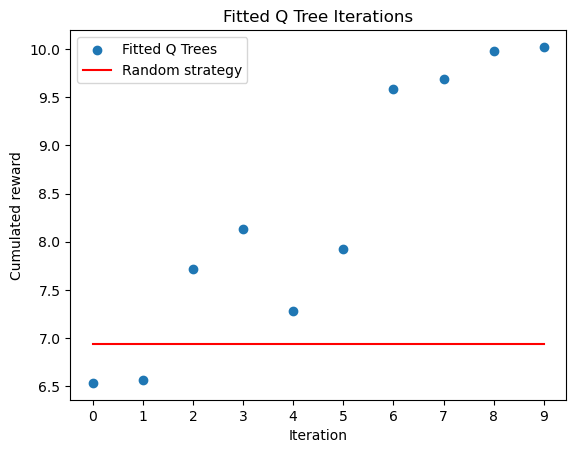

In [14]:
plt.scatter(range(len(cum_reward)-1),np.log10(cum_reward[1:]), label='Fitted Q Trees')
plt.plot(range(len(cum_reward)-1), np.log10([cum_reward[0] for i in range(len(cum_reward)-1)]), label='Random strategy', color='red')
plt.xlabel('Iteration')
plt.ylabel('Cumulated reward')
plt.title('Fitted Q Tree Iterations')
plt.xticks(range(len(cum_reward)-1))
plt.legend()

In [44]:
states.shape

(11, 200, 6)

In [64]:
def plot_tree(states, tree_number):
    list_var = ["T1", "T1_star", "T2", "T2_star", "V", "E"]
    for idx, var in enumerate(list_var):
        plt.plot(np.log10(states[tree_number, :, idx]), label = var)
    plt.legend()

def plot_variable(states, variable_number):
    for i in range(states.shape[0]):
        plt.plot(np.log10(states[i, :, variable_number]))

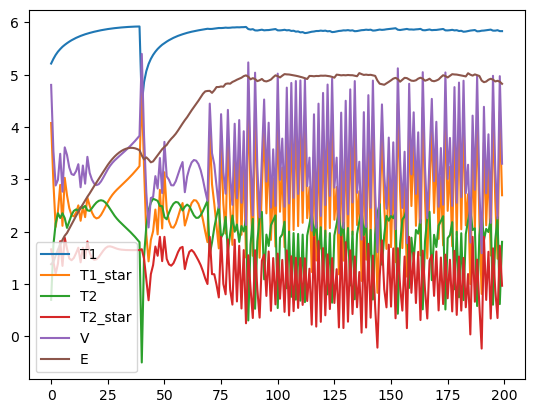

In [69]:
plot_tree(states, 10)

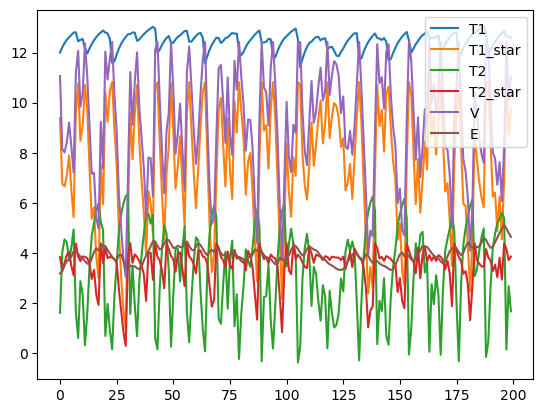

In [49]:
plot_tree(states, 0)

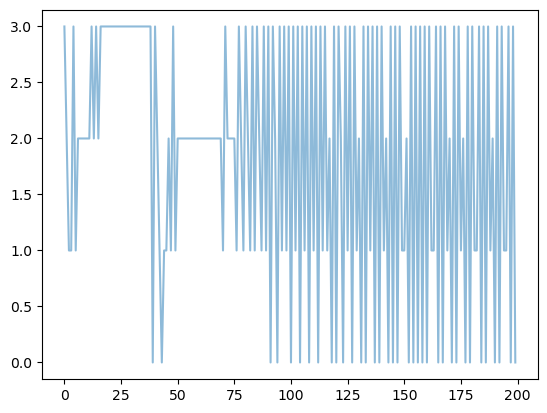

In [62]:
plt.plot(range(200),actions[9,:], alpha=0.5)

In [ ]:
import pickle
filename = 'RB_extratree'
pickle.dump(Tree_test.data, open(filename, 'wb'))